In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [2]:
import urllib.request
url = "https://raw.githubusercontent.com/YuhengHou/MLMA/main/Utils/EasyData.py"
urllib.request.urlretrieve(url, "EasyData.py")

('EasyData.py', <http.client.HTTPMessage at 0x7d5caf4c1910>)

In [3]:
import torch
import warnings
import importlib
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
from EasyData import EasyData
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Load Embedding
embed = torch.load("/content/drive/MyDrive/esm2_delta_embeddings.pt") # embed = torch.load("/content/drive/MyDrive/models/esm2_embeddings.pt")
X, y = embed['X'], embed['y']

if not isinstance(X, np.ndarray): #to np arr
    X = X.cpu().numpy()
    y = y.cpu().numpy()

In [6]:
pipline = EasyData(embedding=X)
final_dataset = pipline.prepare_data()

README.md:   0%|          | 0.00/5.90k [00:00<?, ?B/s]

protein_sequences_metadata.tsv:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/80840 [00:00<?, ? examples/s]

In [7]:
def report_score(model, dataset, to_numeric = False, model_name=None, feature_set=None, feature_dict=None):
  input = dataset.copy()
  for col in input.select_dtypes(include='object').columns:
      input[col] = pd.factorize(input[col])[0]
      input[col] = input[col].astype("category")

  input["Mapped Cancer Stage"] = input["Mapped Cancer Stage"].astype("int")
  # input["Mapped Cancer Stage"] = input["Mapped Cancer Stage"] - 1
  print(input["Mapped Cancer Stage"].value_counts())
  df_split = pipline.stratified_splitting(full_dataset = input, random_state=42)
  X_train = df_split["train"].drop(columns=["Mapped Cancer Stage"])
  y_train = df_split["train"]["Mapped Cancer Stage"]
  model.fit(X_train, y_train)

  X_val = df_split["val"].drop(columns=["Mapped Cancer Stage"])
  y_val = df_split["val"]["Mapped Cancer Stage"]
  y_pred = model.predict(X_val)


  X_test = df_split["test"].drop(columns=["Mapped Cancer Stage"])
  y_test = df_split["test"]["Mapped Cancer Stage"]

  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test, y_pred)
  print(f"ACC of test: {acc:.4f}")

  # Classification report
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred, digits=4))

  if feature_dict is not None and hasattr(model, 'feature_importances_'):
    if model_name not in feature_dict:
        feature_dict[model_name] = {}

    feature_dict[model_name][feature_set] = pd.Series(
        model.feature_importances_, index=X_train.columns
    )

  return acc

In [8]:
def plot_model_comparison(results):
    labels = list(results.keys())  # ['a1', 'a2', 'a3']
    lightgbm_scores = [results[key]['LightGBM'] for key in labels]
    xgboost_scores = [results[key]['XGBoost'] for key in labels]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    rects1 = ax.bar(x - width/2, lightgbm_scores, width, label='LightGBM', color='#FFB347')
    rects2 = ax.bar(x + width/2, xgboost_scores, width, label='XGBoost', color='#FFD700')

    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracy Comparison on Different Input Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.05)
    ax.legend(loc='lower right')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [9]:
LGB_model = LGBMClassifier(verbose=-1, num_class = 4)
XGB_model = XGBClassifier(objective='multi:softprob', num_class=4,eval_metric='mlogloss',use_label_encoder=False,random_state=42)

In [10]:
feature_dict = {}
results = {'a1': {}, 'a2': {}, 'a3': {}}

# a1
print("Performance of a1 - LightGBM")
acc = report_score(model=LGB_model, dataset=final_dataset["a1"], to_numeric=False, model_name="LightGBM", feature_set='a1', feature_dict=feature_dict)
results['a1']['LightGBM'] = acc

print("Performance of a1 - XGBoost")
acc = report_score(model = XGB_model, dataset = final_dataset["a1"], to_numeric = False, model_name="XGBoost", feature_set='a1', feature_dict=feature_dict)
results['a1']['XGBoost'] = acc

# a2
print("Performance of a2 - LightGBM")
acc = report_score(model=LGB_model, dataset=final_dataset["a2"], to_numeric=True, model_name="LightGBM", feature_set='a2', feature_dict=feature_dict)
results['a2']['LightGBM'] = acc

print("Performance of a2 - XGBoost")
acc = report_score(model=XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42, enable_categorical=True), dataset=final_dataset["a2"], to_numeric=True, model_name="XGBoost", feature_set='a2', feature_dict=feature_dict)
results['a2']['XGBoost'] = acc

# a3
print("Performance of a3 - LightGBM")
acc = report_score(model=LGB_model, dataset=final_dataset["a3"], to_numeric=True, model_name="LightGBM", feature_set='a3', feature_dict=feature_dict)
results['a3']['LightGBM'] = acc

print("Performance of a3 - XGBoost")
acc = report_score(model=XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42, enable_categorical=True), dataset=final_dataset["a3"], to_numeric=True, model_name="XGBoost", feature_set='a3', feature_dict=feature_dict)
results['a3']['XGBoost'] = acc

Performance of a1 - LightGBM
Mapped Cancer Stage
1    25572
0     7182
3     3208
2     2296
Name: count, dtype: int64
ACC of test: 0.7462

Classification Report:
              precision    recall  f1-score   support

           0     0.9429    0.2296    0.3693      1437
           1     0.7267    0.9977    0.8409      5115
           2     0.9817    0.2326    0.3761       460
           3     0.9885    0.2675    0.4211       643

    accuracy                         0.7462      7655
   macro avg     0.9099    0.4319    0.5018      7655
weighted avg     0.8046    0.7462    0.6892      7655

Performance of a1 - XGBoost
Mapped Cancer Stage
1    25572
0     7182
3     3208
2     2296
Name: count, dtype: int64
ACC of test: 0.8077

Classification Report:
              precision    recall  f1-score   support

           0     0.9288    0.4447    0.6014      1437
           1     0.7817    0.9926    0.8746      5115
           2     0.9886    0.3783    0.5472       460
           3     0.9899

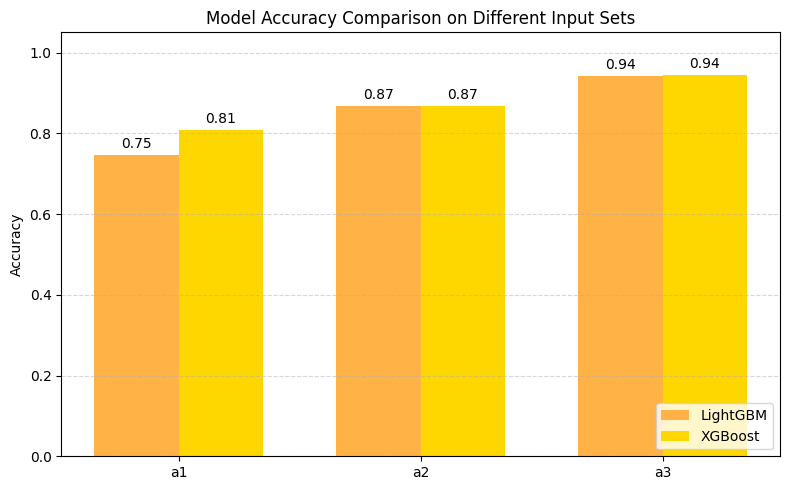

In [11]:
plot_model_comparison(results)

In [12]:
#Feature importance
def plot_top_features(feature_dict, top_n=10):
    for model_name, model_data in feature_dict.items():
        for feature_set, series in model_data.items():
            top_features = series.sort_values(ascending=False).head(top_n)
            plt.figure(figsize=(8, 5))
            top_features[::-1].plot(kind='barh')
            plt.title(f"{model_name} Top {top_n} Features - {feature_set}")
            plt.xlabel("Importance")
            plt.tight_layout()
            plt.show()

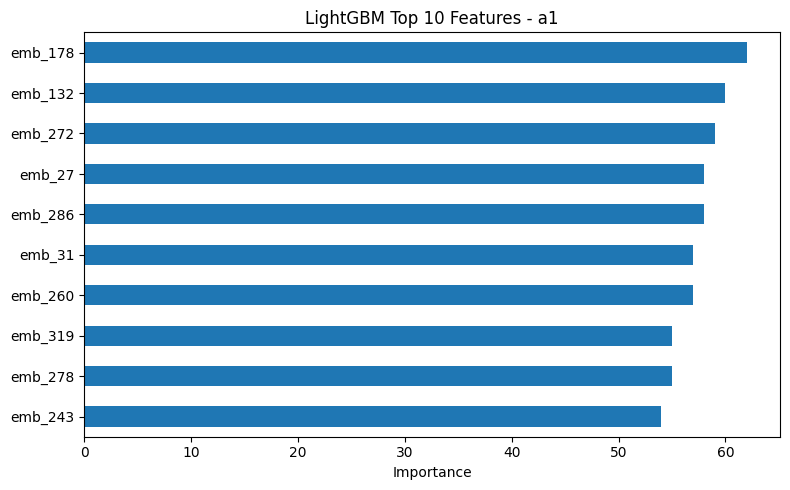

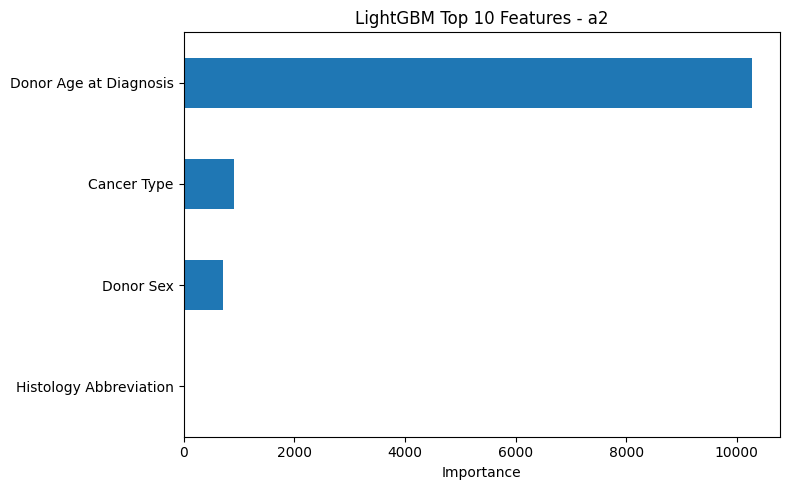

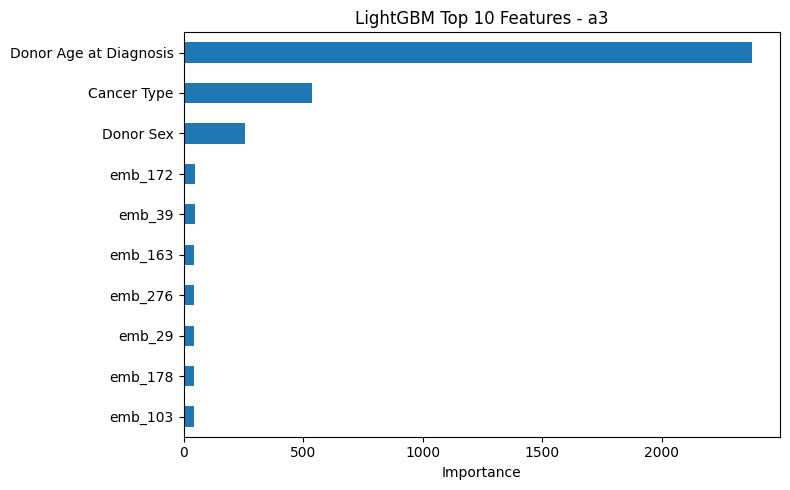

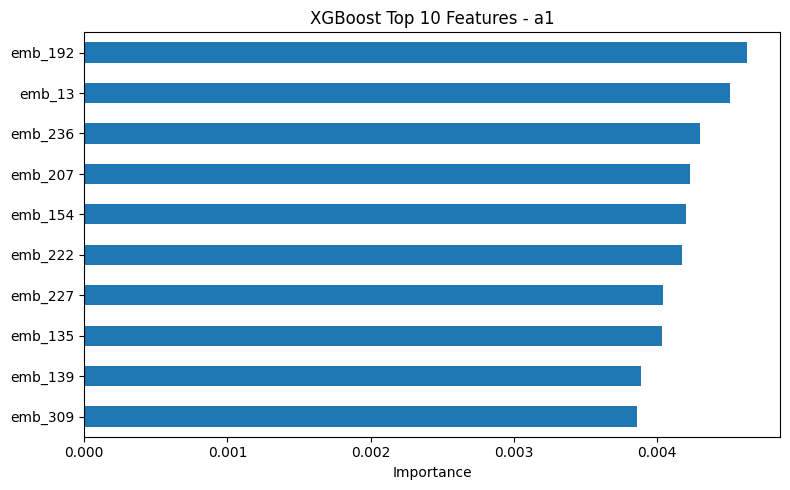

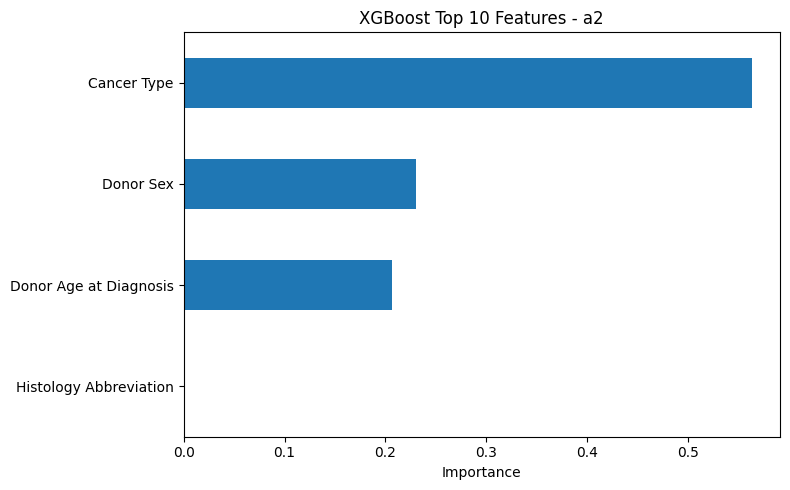

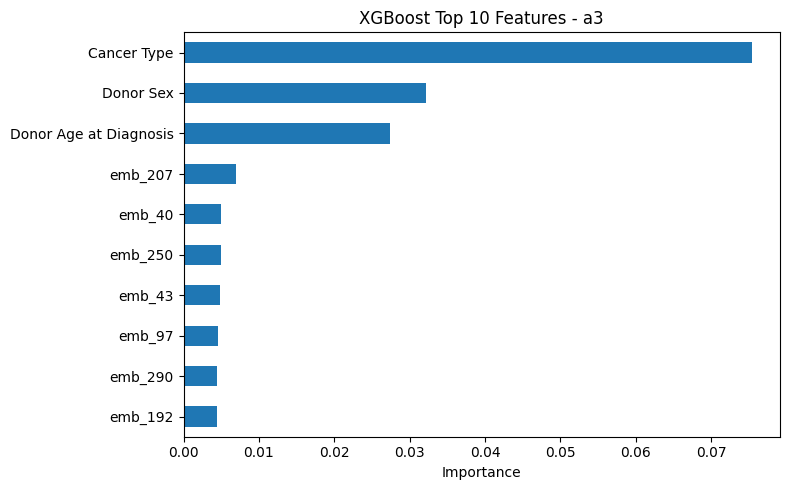

In [13]:
plot_top_features(feature_dict, top_n=10)

Evaluating LightGBM on a1...
Evaluating XGBoost on a1...
Evaluating LightGBM on a2...
Evaluating XGBoost on a2...
Evaluating LightGBM on a3...
Evaluating XGBoost on a3...


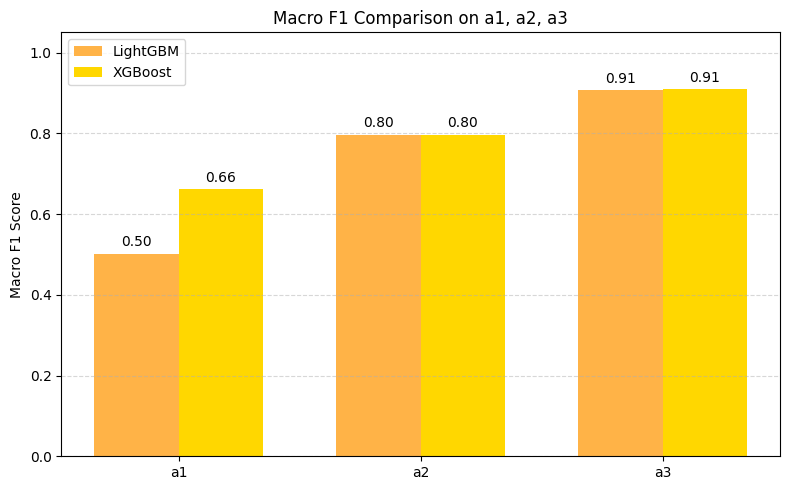

In [14]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Modify your report_score to return F1:
def report_score_with_f1(model, dataset, to_numeric=False):
    input = dataset.copy()
    for col in input.select_dtypes(include='object').columns:
        input[col] = pd.factorize(input[col])[0]
        input[col] = input[col].astype("category")

    input["Mapped Cancer Stage"] = input["Mapped Cancer Stage"].astype("int")
    df_split = pipline.stratified_splitting(full_dataset=input, random_state=42)

    X_train = df_split["train"].drop(columns=["Mapped Cancer Stage"])
    y_train = df_split["train"]["Mapped Cancer Stage"]
    model.fit(X_train, y_train)

    X_test = df_split["test"].drop(columns=["Mapped Cancer Stage"])
    y_test = df_split["test"]["Mapped Cancer Stage"]
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, digits=4, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']
    return macro_f1

# === Compute macro F1 for each combination ===
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

macro_f1_results = {'a1': {}, 'a2': {}, 'a3': {}}

for method in ['a1', 'a2', 'a3']:
    print(f"Evaluating LightGBM on {method}...")
    model = LGBMClassifier(verbose=-1, num_class=4)
    macro_f1_results[method]['LightGBM'] = report_score_with_f1(model, final_dataset[method], to_numeric=True)

    print(f"Evaluating XGBoost on {method}...")
    model = XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42, enable_categorical=True)
    macro_f1_results[method]['XGBoost'] = report_score_with_f1(model, final_dataset[method], to_numeric=True)

# === Plot Macro F1 ===
labels = list(macro_f1_results.keys())  # ['a1', 'a2', 'a3']
xgboost_f1 = [macro_f1_results[k]['XGBoost'] for k in labels]
lightgbm_f1 = [macro_f1_results[k]['LightGBM'] for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, lightgbm_f1, width, label='LightGBM', color='#FFB347')
rects2 = ax.bar(x + width/2, xgboost_f1, width, label='XGBoost', color='#FFD700')

ax.set_ylabel('Macro F1 Score')
ax.set_title('Macro F1 Comparison on a1, a2, a3')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.legend(loc='upper left')

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("macro_f1_by_dataset.png")
plt.show()


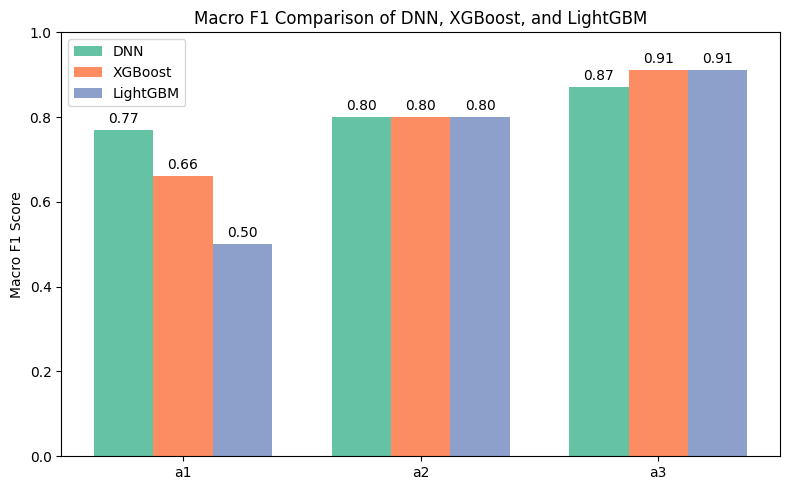

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Macro F1 scores for a1, a2, a3 across three models
f1_scores = {
    'a1': {'DNN': 0.77, 'XGBoost': 0.66, 'LightGBM': 0.50},
    'a2': {'DNN': 0.80, 'XGBoost': 0.80, 'LightGBM': 0.80},
    'a3': {'DNN': 0.87, 'XGBoost': 0.91, 'LightGBM': 0.91}
}

labels = list(f1_scores.keys())
dnn = [f1_scores[k]['DNN'] for k in labels]
xgb = [f1_scores[k]['XGBoost'] for k in labels]
lgb = [f1_scores[k]['LightGBM'] for k in labels]

x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width, dnn, width, label='DNN', color='#66c2a5')
bars2 = ax.bar(x, xgb, width, label='XGBoost', color='#fc8d62')
bars3 = ax.bar(x + width, lgb, width, label='LightGBM', color='#8da0cb')

# Add text annotations
for bar_group in [bars1, bars2, bars3]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

ax.set_ylabel('Macro F1 Score')
ax.set_title('Macro F1 Comparison of DNN, XGBoost, and LightGBM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1])
ax.legend()
plt.tight_layout()
plt.savefig("macro_f1_comparison_all_models.png")
plt.show()


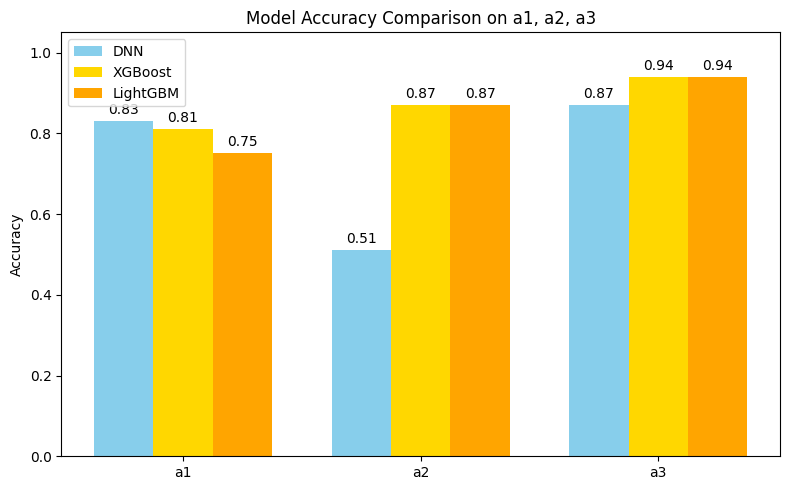

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values
datasets = ['a1', 'a2', 'a3']
dnn_acc = [0.83, 0.51, 0.87]
xgb_acc = [0.81, 0.87, 0.94]
lgbm_acc = [0.75, 0.87, 0.94]

x = np.arange(len(datasets))
width = 0.25

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width, dnn_acc, width, label='DNN', color='skyblue')
bars2 = ax.bar(x, xgb_acc, width, label='XGBoost', color='gold')
bars3 = ax.bar(x + width, lgbm_acc, width, label='LightGBM', color='orange')

# Add labels
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison on a1, a2, a3')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim(0, 1.05)
ax.legend()

# Annotate bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


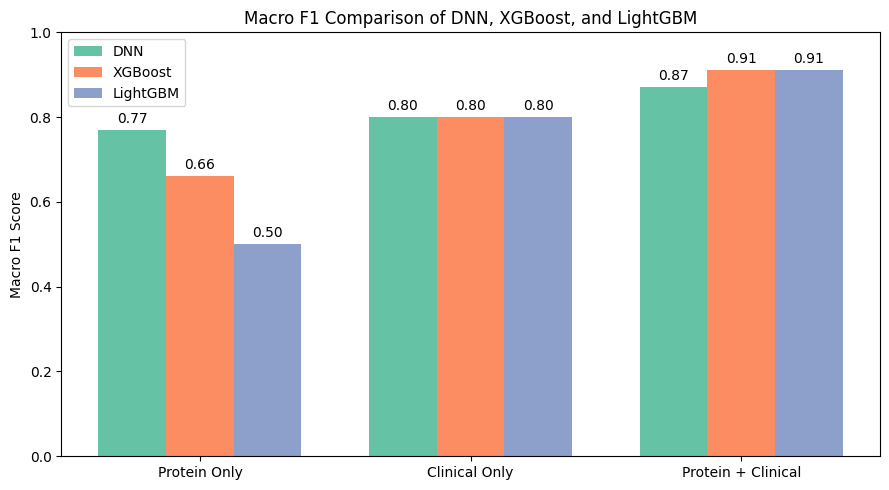

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Macro F1 scores for each dataset across three models
f1_scores = {
    'Protein Only': {'DNN': 0.77, 'XGBoost': 0.66, 'LightGBM': 0.50},          # a1
    'Clinical Only': {'DNN': 0.80, 'XGBoost': 0.80, 'LightGBM': 0.80},         # a2
    'Protein + Clinical': {'DNN': 0.87, 'XGBoost': 0.91, 'LightGBM': 0.91}     # a3
}

labels = list(f1_scores.keys())
dnn = [f1_scores[k]['DNN'] for k in labels]
xgb = [f1_scores[k]['XGBoost'] for k in labels]
lgb = [f1_scores[k]['LightGBM'] for k in labels]

x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(9, 5))
bars1 = ax.bar(x - width, dnn, width, label='DNN', color='#66c2a5')
bars2 = ax.bar(x, xgb, width, label='XGBoost', color='#fc8d62')
bars3 = ax.bar(x + width, lgb, width, label='LightGBM', color='#8da0cb')

# Add text annotations
for bar_group in [bars1, bars2, bars3]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

ax.set_ylabel('Macro F1 Score')
ax.set_title('Macro F1 Comparison of DNN, XGBoost, and LightGBM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1])
ax.legend()
plt.tight_layout()
plt.savefig("macro_f1_comparison_all_models_named.png")
plt.show()


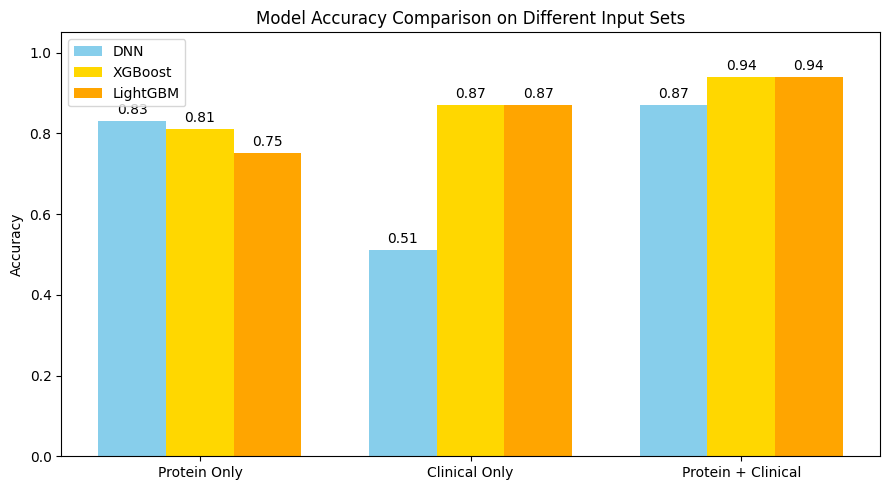

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values
datasets = ['Protein Only', 'Clinical Only', 'Protein + Clinical']  # a1, a2, a3
dnn_acc = [0.83, 0.51, 0.87]
xgb_acc = [0.81, 0.87, 0.94]
lgbm_acc = [0.75, 0.87, 0.94]

x = np.arange(len(datasets))
width = 0.25

# Create plot
fig, ax = plt.subplots(figsize=(9, 5))
bars1 = ax.bar(x - width, dnn_acc, width, label='DNN', color='skyblue')
bars2 = ax.bar(x, xgb_acc, width, label='XGBoost', color='gold')
bars3 = ax.bar(x + width, lgbm_acc, width, label='LightGBM', color='orange')

# Add labels
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison on Different Input Sets')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim(0, 1.05)
ax.legend()

# Annotate bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("accuracy_comparison_all_models_named.png")
plt.show()
